## Notebook for hyperparameter-tuning for TimeVAE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from models.data_generating_models.time_vae import TimeVAE
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging
from config import data_generation_config
import wandb

## Load train, val, and test

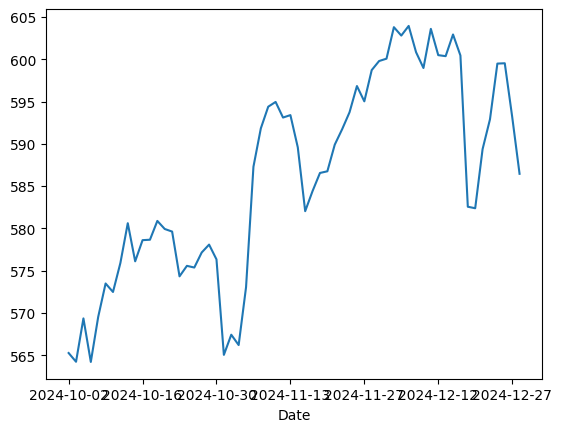

In [2]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices_train.csv", index_col=0)

val_data = pd.read_csv("../data/raw/spy_daily_closing_prices_val.csv", index_col=0)

val_data = val_data["Close"]
val_data.plot(use_index=True)
val_data = np.array([val_data.values[i:i+30] for i in range(len(val_data)-30 + 1)])
val_data = pd.DataFrame(val_data)
val_data = val_data.div(val_data.iloc[:, 0], axis=0)

test_data = pd.read_csv("../data/raw/spy_daily_closing_prices_test.csv", index_col=0)
test_data = test_data["Close"]
test_data = np.array([test_data.values[i:i+30] for i in range(len(test_data)-30 + 1)])
test_data = pd.DataFrame(test_data)
test_data = test_data.div(test_data.iloc[:, 0], axis=0)

In [3]:
wandb.login(key="52ea61320bbc9ee2b773e909700366e65977cd0f")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sarogde (sarogde-ntnu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/sondrerogde/.netrc


True

In [4]:
sweep_config = {
    'method': 'bayes',  # or 'grid', 'bayes'
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'latent_dim': {
            'values': [4, 8, 16, 32]
        },
        'hidden_layer_sizes': {
            'values': [[8, 8], [8, 8, 8], [16, 16, 16], [32, 32]]
        },
        'reconstruction_wt': {
            'values': [1.0, 3.0, 5.0]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'trend_poly': {
            'values': [0, 1, 2]
        },
    }
}

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project="timevae_hyperopt")
sweep_id = "mr5gggtb"

In [6]:
def objective(config):
    hyperparameters = {
        "sequence_length": 30,
        "latent_dim": config.latent_dim,
        "hidden_layer_sizes": config.hidden_layer_sizes,
        "reconstruction_wt": config.reconstruction_wt,
        "batch_size": config.batch_size,
        "use_residual_conn": True,
        "trend_poly": config.trend_poly
    }
    
    model = TimeVAE(train_data=train_data, N=data_generation_config["N"], M=data_generation_config["M"], load_params=False, config=hyperparameters)
    print("Training model")
    model.fit_params_to_data()
    
    print("Generating data")
    model.generate_data()

    df_post_processed = post_processing(model.synth_data, **post_processing_config)

    print('Hedging')
    val_loss = hedging(df_post_processed, val_data)

    return val_loss

def main():
    wandb.init()
    val_loss = objective(wandb.config)
    wandb.log({"val_loss": val_loss,  "loss": val_loss})

In [7]:
wandb.agent(sweep_id, function=main, count=30, project="timevae_hyperopt")

wandb: Agent Starting Run: ds3kokqe with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [8, 8, 8]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 5
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.003288877988, Time: 89.70s
Epoch 200, Training Loss: 0.000837245327, Time: 179.45s
Epoch 300, Training Loss: 0.000331318921, Time: 259.98s
Epoch 400, Training Loss: 0.000169206149, Time: 340.31s
Epoch 500, Training Loss: 0.000035120194, Time: 421.92s
Epoch 600, Training Loss: 0.000012197098, Time: 503.03s
Epoch 700, Training Loss: 0.000007717398, Time: 583.69s
Epoch 800, Training Loss: 0.000006009266, Time: 667.03s
Epoch 900, Training Loss: 0.000005303155, Time: 756.43s
Epoch 1000, Training Loss: 0.000004799227, Time: 840.81s
Validation Loss: 0.005877564661


loss,▁
val_loss,▁
loss,0.00588
val_loss,0.00588


wandb: Agent Starting Run: xufhqgt0 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 4
wandb: 	reconstruction_wt: 3
wandb: 	trend_poly: 2


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000877920982, Time: 79.27s
Epoch 200, Training Loss: 0.000387547658, Time: 166.87s
Epoch 300, Training Loss: 0.000156685222, Time: 250.82s
Epoch 400, Training Loss: 0.000037874147, Time: 336.21s
Epoch 500, Training Loss: 0.000014998794, Time: 421.72s
Epoch 600, Training Loss: 0.000009381877, Time: 508.35s
Epoch 700, Training Loss: 0.000006774613, Time: 595.14s
Epoch 800, Training Loss: 0.000005150992, Time: 681.98s
Epoch 900, Training Loss: 0.000004409342, Time: 774.61s
Epoch 1000, Training Loss: 0.000003767955, Time: 862.04s
Validation Loss: 0.003184411675


loss,▁
val_loss,▁
loss,0.00318
val_loss,0.00318


wandb: Agent Starting Run: pp9cv7uh with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [8, 8, 8]
wandb: 	latent_dim: 4
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 2


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001530644187, Time: 88.91s
Epoch 200, Training Loss: 0.001232093846, Time: 177.23s
Epoch 300, Training Loss: 0.000039061115, Time: 264.71s
Epoch 400, Training Loss: 0.000012560611, Time: 359.53s
Epoch 500, Training Loss: 0.000007969869, Time: 451.28s
Epoch 600, Training Loss: 0.000006186196, Time: 542.30s
Epoch 700, Training Loss: 0.000004874910, Time: 637.04s
Epoch 800, Training Loss: 0.000003673843, Time: 729.93s
Epoch 900, Training Loss: 0.000002665270, Time: 822.34s
Epoch 1000, Training Loss: 0.000001935708, Time: 910.28s
Validation Loss: 0.002604267327


loss,▁
val_loss,▁
loss,0.0026
val_loss,0.0026


wandb: Agent Starting Run: 4mqi5z0g with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [8, 8, 8]
wandb: 	latent_dim: 4
wandb: 	reconstruction_wt: 5
wandb: 	trend_poly: 2


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.003685268771, Time: 92.53s
Epoch 200, Training Loss: 0.000526605599, Time: 183.24s
Epoch 300, Training Loss: 0.000459583745, Time: 276.53s
Epoch 400, Training Loss: 0.000386432451, Time: 366.42s
Epoch 500, Training Loss: 0.000187880088, Time: 466.31s
Epoch 600, Training Loss: 0.000022421740, Time: 575.94s
Epoch 700, Training Loss: 0.000006824373, Time: 683.33s
Epoch 800, Training Loss: 0.000003487880, Time: 790.06s
Epoch 900, Training Loss: 0.000002537169, Time: 899.30s
Epoch 1000, Training Loss: 0.000002438973, Time: 1012.59s
Validation Loss: 0.003151586978


loss,▁
val_loss,▁
loss,0.00315
val_loss,0.00315


wandb: Agent Starting Run: y29ujki6 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [16, 16, 16]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 5
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.007052558882, Time: 100.80s
Epoch 200, Training Loss: 0.000238351714, Time: 203.90s
Epoch 300, Training Loss: 0.000169824804, Time: 307.04s
Epoch 400, Training Loss: 0.000102620386, Time: 410.00s
Epoch 500, Training Loss: 0.000028142772, Time: 514.14s
Epoch 600, Training Loss: 0.000010601179, Time: 617.65s
Epoch 700, Training Loss: 0.000006982746, Time: 722.08s
Epoch 800, Training Loss: 0.000005703457, Time: 825.17s
Epoch 900, Training Loss: 0.000004772038, Time: 928.32s
Epoch 1000, Training Loss: 0.000004132038, Time: 1031.87s
Validation Loss: 0.003582551377


loss,▁
val_loss,▁
loss,0.00358
val_loss,0.00358


wandb: Agent Starting Run: k0ts3k3t with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer_sizes: [8, 8]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 3
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001041335191, Time: 103.94s
Epoch 200, Training Loss: 0.000401457111, Time: 210.79s
Epoch 300, Training Loss: 0.000102165549, Time: 317.05s
Epoch 400, Training Loss: 0.000022409823, Time: 424.73s
Epoch 500, Training Loss: 0.000004826620, Time: 532.31s
Epoch 600, Training Loss: 0.000002209627, Time: 642.92s
Epoch 700, Training Loss: 0.000001556239, Time: 750.53s
Epoch 800, Training Loss: 0.000001159685, Time: 859.42s
Epoch 900, Training Loss: 0.000001015509, Time: 966.56s
Epoch 1000, Training Loss: 0.000000895311, Time: 1071.66s
Validation Loss: 0.001699772896


loss,▁
val_loss,▁
loss,0.0017
val_loss,0.0017


wandb: Agent Starting Run: kuzxdk32 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 4
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000690421046, Time: 110.25s
Epoch 200, Training Loss: 0.000004178807, Time: 222.24s
Epoch 300, Training Loss: 0.000000851846, Time: 331.85s
Epoch 400, Training Loss: 0.000000217145, Time: 443.18s
Epoch 500, Training Loss: 0.000000103862, Time: 552.66s
Epoch 600, Training Loss: 0.000000041669, Time: 661.32s
Epoch 700, Training Loss: 0.000000022475, Time: 774.44s
Epoch 800, Training Loss: 0.000000011023, Time: 887.08s
Epoch 900, Training Loss: 0.000000007254, Time: 995.90s
Epoch 1000, Training Loss: 0.000000005590, Time: 1104.46s
Validation Loss: 0.001812507049


loss,▁
val_loss,▁
loss,0.00181
val_loss,0.00181


wandb: Agent Starting Run: ch7a5md1 with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer_sizes: [8, 8, 8]
wandb: 	latent_dim: 32
wandb: 	reconstruction_wt: 5
wandb: 	trend_poly: 2


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001325290705, Time: 109.59s
Epoch 200, Training Loss: 0.000271117893, Time: 218.87s
Epoch 300, Training Loss: 0.000070029158, Time: 327.37s
Epoch 400, Training Loss: 0.000053177850, Time: 437.05s
Epoch 500, Training Loss: 0.000042093234, Time: 547.98s
Epoch 600, Training Loss: 0.000026820498, Time: 656.96s
Epoch 700, Training Loss: 0.000015044497, Time: 765.22s
Epoch 800, Training Loss: 0.000011854592, Time: 874.13s
Epoch 900, Training Loss: 0.000010390769, Time: 983.31s
Epoch 1000, Training Loss: 0.000009882569, Time: 1092.09s
Validation Loss: 0.005103308707


loss,▁
val_loss,▁
loss,0.0051
val_loss,0.0051


wandb: Agent Starting Run: f3xfu8q0 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [8, 8, 8]
wandb: 	latent_dim: 4
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000281918020, Time: 103.19s
Epoch 200, Training Loss: 0.000077375192, Time: 207.09s
Epoch 300, Training Loss: 0.000007075302, Time: 305.01s
Epoch 400, Training Loss: 0.000000778177, Time: 395.55s
Epoch 500, Training Loss: 0.000000181414, Time: 487.43s
Epoch 600, Training Loss: 0.000000072046, Time: 578.54s
Epoch 700, Training Loss: 0.000000045208, Time: 670.59s
Epoch 800, Training Loss: 0.000000030930, Time: 763.93s
Epoch 900, Training Loss: 0.000000020901, Time: 857.25s
Epoch 1000, Training Loss: 0.000000021755, Time: 950.25s
Validation Loss: 0.003792714560


loss,▁
val_loss,▁
loss,0.00379
val_loss,0.00379


wandb: Agent Starting Run: 1zw8ghf9 with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 3
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000608912685, Time: 95.03s
Epoch 200, Training Loss: 0.000035403391, Time: 190.95s
Epoch 300, Training Loss: 0.000003410558, Time: 285.52s
Epoch 400, Training Loss: 0.000000698934, Time: 414.69s
Epoch 500, Training Loss: 0.000000308760, Time: 526.31s
Epoch 600, Training Loss: 0.000000182727, Time: 647.53s
Epoch 700, Training Loss: 0.000000139484, Time: 762.49s
Epoch 800, Training Loss: 0.000000108455, Time: 879.29s
Epoch 900, Training Loss: 0.000000099388, Time: 1001.58s
Epoch 1000, Training Loss: 0.000000083204, Time: 1118.49s
Validation Loss: 0.002924959641


loss,▁
val_loss,▁
loss,0.00292
val_loss,0.00292


wandb: Agent Starting Run: oo8vheqp with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [16, 16, 16]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000322552018, Time: 112.41s
Epoch 200, Training Loss: 0.000289661613, Time: 231.65s
Epoch 300, Training Loss: 0.000226601411, Time: 345.87s
Epoch 400, Training Loss: 0.000085119095, Time: 467.90s
Epoch 500, Training Loss: 0.000015316347, Time: 589.86s
Epoch 600, Training Loss: 0.000005984789, Time: 711.71s
Epoch 700, Training Loss: 0.000003411212, Time: 834.81s
Epoch 800, Training Loss: 0.000002638834, Time: 946.53s
Epoch 900, Training Loss: 0.000001980635, Time: 1066.88s
Epoch 1000, Training Loss: 0.000001569530, Time: 1179.96s
Validation Loss: 0.000400925230


loss,▁
val_loss,▁
loss,0.0004
val_loss,0.0004


wandb: Agent Starting Run: xsxg8hf6 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001377608659, Time: 165.44s
Epoch 200, Training Loss: 0.000056174786, Time: 361.46s
Epoch 300, Training Loss: 0.000006658877, Time: 534.86s
Epoch 400, Training Loss: 0.000000987106, Time: 714.05s
Epoch 500, Training Loss: 0.000000312224, Time: 893.28s
Epoch 600, Training Loss: 0.000000148036, Time: 1078.32s
Epoch 700, Training Loss: 0.000000092715, Time: 1270.10s
Epoch 800, Training Loss: 0.000000074298, Time: 1454.26s
Epoch 900, Training Loss: 0.000000057659, Time: 1670.24s
Epoch 1000, Training Loss: 0.000000059154, Time: 1845.53s
Validation Loss: 0.002579608234


loss,▁
val_loss,▁
loss,0.00258
val_loss,0.00258


wandb: Agent Starting Run: aief1zpb with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 3
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001798990316, Time: 186.62s
Epoch 200, Training Loss: 0.001004351213, Time: 359.74s
Epoch 300, Training Loss: 0.000878778855, Time: 532.85s
Epoch 400, Training Loss: 0.000363053946, Time: 706.96s
Epoch 500, Training Loss: 0.000057279622, Time: 884.89s
Epoch 600, Training Loss: 0.000010770456, Time: 1062.59s
Epoch 700, Training Loss: 0.000004084613, Time: 1241.97s
Epoch 800, Training Loss: 0.000002448157, Time: 1421.31s
Epoch 900, Training Loss: 0.000002290940, Time: 1605.77s
Epoch 1000, Training Loss: 0.000001177562, Time: 1784.38s
Validation Loss: 0.003233345924


loss,▁
val_loss,▁
loss,0.00323
val_loss,0.00323


wandb: Agent Starting Run: 5df1rysu with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001383947342, Time: 185.55s
Epoch 200, Training Loss: 0.000485537171, Time: 367.15s
Epoch 300, Training Loss: 0.000463133335, Time: 546.74s
Epoch 400, Training Loss: 0.000449301034, Time: 742.03s
Epoch 500, Training Loss: 0.000438998218, Time: 920.91s
Epoch 600, Training Loss: 0.000428045810, Time: 1065.85s
Epoch 700, Training Loss: 0.000431166928, Time: 1182.07s
Epoch 800, Training Loss: 0.000412545112, Time: 1294.91s
Epoch 900, Training Loss: 0.000404384300, Time: 1407.34s
Epoch 1000, Training Loss: 0.000387430484, Time: 1515.65s
Validation Loss: 0.000146282051


loss,▁
val_loss,▁
loss,0.00015
val_loss,0.00015


wandb: Agent Starting Run: km07i6h3 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.002134556515, Time: 110.25s
Epoch 200, Training Loss: 0.000377818086, Time: 225.84s
Epoch 300, Training Loss: 0.000222556383, Time: 339.03s
Epoch 400, Training Loss: 0.000092937943, Time: 450.03s
Epoch 500, Training Loss: 0.000019518297, Time: 562.20s
Epoch 600, Training Loss: 0.000003082695, Time: 674.11s
Epoch 700, Training Loss: 0.000000831225, Time: 785.89s
Epoch 800, Training Loss: 0.000000446571, Time: 903.09s
Epoch 900, Training Loss: 0.000000336803, Time: 1019.45s
Epoch 1000, Training Loss: 0.000000229376, Time: 1137.38s
Validation Loss: 0.001252215356


loss,▁
val_loss,▁
loss,0.00125
val_loss,0.00125


wandb: Agent Starting Run: 6owm911w with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.002167501723, Time: 114.70s
Epoch 200, Training Loss: 0.000260100790, Time: 240.79s
Epoch 300, Training Loss: 0.000156253123, Time: 365.86s
Epoch 400, Training Loss: 0.000137491582, Time: 482.54s
Epoch 500, Training Loss: 0.000129815998, Time: 608.77s
Epoch 600, Training Loss: 0.000106562060, Time: 722.86s
Epoch 700, Training Loss: 0.000074316150, Time: 836.67s
Epoch 800, Training Loss: 0.000018895333, Time: 953.17s
Epoch 900, Training Loss: 0.000003580910, Time: 1072.53s
Epoch 1000, Training Loss: 0.000001576152, Time: 1195.91s
Validation Loss: 0.002265108051


loss,▁
val_loss,▁
loss,0.00227
val_loss,0.00227


wandb: Agent Starting Run: afarelt2 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001423669420, Time: 120.17s
Epoch 200, Training Loss: 0.000252456011, Time: 243.70s
Epoch 300, Training Loss: 0.000060702198, Time: 358.08s
Epoch 400, Training Loss: 0.000018822903, Time: 481.26s
Epoch 500, Training Loss: 0.000002595286, Time: 597.86s
Epoch 600, Training Loss: 0.000000732667, Time: 722.49s
Epoch 700, Training Loss: 0.000000426596, Time: 845.02s
Epoch 800, Training Loss: 0.000000388789, Time: 968.16s
Epoch 900, Training Loss: 0.000000270009, Time: 1084.86s
Epoch 1000, Training Loss: 0.000000212120, Time: 1200.34s
Validation Loss: 0.001062966650


loss,▁
val_loss,▁
loss,0.00106
val_loss,0.00106


wandb: Agent Starting Run: 0xtf54by with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000409080688, Time: 116.33s
Epoch 200, Training Loss: 0.000171634013, Time: 231.69s
Epoch 300, Training Loss: 0.000107756409, Time: 359.03s
Epoch 400, Training Loss: 0.000055811048, Time: 471.61s
Epoch 500, Training Loss: 0.000022017682, Time: 574.23s
Epoch 600, Training Loss: 0.000005505869, Time: 683.01s
Epoch 700, Training Loss: 0.000002039949, Time: 802.86s
Epoch 800, Training Loss: 0.000001283797, Time: 943.40s
Epoch 900, Training Loss: 0.000000892716, Time: 1064.94s
Epoch 1000, Training Loss: 0.000000640805, Time: 1190.94s
Validation Loss: 0.001045673154


loss,▁
val_loss,▁
loss,0.00105
val_loss,0.00105


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ny6umxtm with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000454870374, Time: 128.15s
Epoch 200, Training Loss: 0.000405253056, Time: 250.69s
Epoch 300, Training Loss: 0.000323613201, Time: 369.94s
Epoch 400, Training Loss: 0.000148040892, Time: 486.88s
Epoch 500, Training Loss: 0.000080563392, Time: 607.06s
Epoch 600, Training Loss: 0.000027804802, Time: 731.84s
Epoch 700, Training Loss: 0.000004215125, Time: 859.94s
Epoch 800, Training Loss: 0.000001216966, Time: 983.69s
Epoch 900, Training Loss: 0.000000675935, Time: 1108.77s
Epoch 1000, Training Loss: 0.000000505690, Time: 1228.06s
Validation Loss: 0.002576756058


loss,▁
val_loss,▁
loss,0.00258
val_loss,0.00258


wandb: Agent Starting Run: tmrbpbu9 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000763345177, Time: 121.25s
Epoch 200, Training Loss: 0.000162512370, Time: 240.60s
Epoch 300, Training Loss: 0.000081217800, Time: 355.90s
Epoch 400, Training Loss: 0.000010875644, Time: 477.54s
Epoch 500, Training Loss: 0.000001686165, Time: 604.75s
Epoch 600, Training Loss: 0.000000547162, Time: 726.28s
Epoch 700, Training Loss: 0.000000335822, Time: 853.73s
Epoch 800, Training Loss: 0.000000205486, Time: 979.05s
Epoch 900, Training Loss: 0.000000187626, Time: 1102.75s
Epoch 1000, Training Loss: 0.000000136920, Time: 1226.98s
Validation Loss: 0.002570395125


loss,▁
val_loss,▁
loss,0.00257
val_loss,0.00257


wandb: Agent Starting Run: eroabzho with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [16, 16, 16]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model


Run eroabzho errored:
Traceback (most recent call last):
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_89970/2612305251.py", line 28, in main
    val_loss = objective(wandb.config)
               ^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_89970/2612305251.py", line 14, in objective
    model.fit_params_to_data()
  File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/time_vae.py", line 60, in fit_params_to_data
    train_vae(
  File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/TimeVAE/src/vae/vae_utils.py", line 99, in train_vae
    vae.fit_on_data(train_data, max_epochs, verbose)
  File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/TimeVAE/src/vae/vae_base.p

Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000994458044, Time: 121.70s
Epoch 200, Training Loss: 0.000360670302, Time: 247.51s
Epoch 300, Training Loss: 0.000144679388, Time: 369.49s
Epoch 400, Training Loss: 0.000017690852, Time: 489.40s
Epoch 500, Training Loss: 0.000002062788, Time: 605.59s
Epoch 600, Training Loss: 0.000000728441, Time: 715.54s
Epoch 700, Training Loss: 0.000000382425, Time: 823.87s
Epoch 800, Training Loss: 0.000000328722, Time: 934.45s
Epoch 900, Training Loss: 0.000000258043, Time: 1044.18s
Epoch 1000, Training Loss: 0.000000852461, Time: 1156.52s
Validation Loss: 0.001730804914


loss,▁
val_loss,▁
loss,0.00173
val_loss,0.00173


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s5k34rf1 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [16, 16, 16]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 3
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.003099636885, Time: 126.89s
Epoch 200, Training Loss: 0.001266744843, Time: 249.87s
Epoch 300, Training Loss: 0.000993268208, Time: 379.66s
Epoch 400, Training Loss: 0.000332774886, Time: 496.18s
Epoch 500, Training Loss: 0.000068775145, Time: 617.84s
Epoch 600, Training Loss: 0.000021400594, Time: 747.38s
Epoch 700, Training Loss: 0.000011550333, Time: 864.74s
Epoch 800, Training Loss: 0.000008285028, Time: 982.55s
Epoch 900, Training Loss: 0.000005995499, Time: 1102.55s
Epoch 1000, Training Loss: 0.000004601889, Time: 1225.77s
Validation Loss: 0.003217855468


loss,▁
val_loss,▁
loss,0.00322
val_loss,0.00322


wandb: Agent Starting Run: fzvohk3l with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001047304744, Time: 127.48s
Epoch 200, Training Loss: 0.000331427886, Time: 250.14s
Epoch 300, Training Loss: 0.000192926139, Time: 379.47s
Epoch 400, Training Loss: 0.000145865271, Time: 510.29s
Epoch 500, Training Loss: 0.000096613420, Time: 640.12s
Epoch 600, Training Loss: 0.000065329670, Time: 757.36s
Epoch 700, Training Loss: 0.000046513035, Time: 876.79s
Epoch 800, Training Loss: 0.000015165593, Time: 995.78s
Epoch 900, Training Loss: 0.000003284244, Time: 1110.98s
Epoch 1000, Training Loss: 0.000001322407, Time: 1225.05s
Validation Loss: 0.000876424660


loss,▁
val_loss,▁
loss,0.00088
val_loss,0.00088


wandb: Agent Starting Run: 4tsshfyz with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 3
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000869153210, Time: 115.18s
Epoch 200, Training Loss: 0.000843438070, Time: 232.54s
Epoch 300, Training Loss: 0.000058712020, Time: 347.68s
Epoch 400, Training Loss: 0.000010197038, Time: 461.35s
Epoch 500, Training Loss: 0.000002309257, Time: 573.56s
Epoch 600, Training Loss: 0.000000875408, Time: 685.56s
Epoch 700, Training Loss: 0.000000583249, Time: 796.29s
Epoch 800, Training Loss: 0.000000583129, Time: 923.66s
Epoch 900, Training Loss: 0.000000405212, Time: 1046.82s
Epoch 1000, Training Loss: 0.000000353230, Time: 1194.91s
Validation Loss: 0.002984014107


loss,▁
val_loss,▁
loss,0.00298
val_loss,0.00298


wandb: Agent Starting Run: 8u04t6zz with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000943475672, Time: 111.75s
Epoch 200, Training Loss: 0.000376054707, Time: 225.58s
Epoch 300, Training Loss: 0.000002571991, Time: 335.11s
Epoch 400, Training Loss: 0.000001150930, Time: 446.57s
Epoch 500, Training Loss: 0.000000764515, Time: 557.57s
Epoch 600, Training Loss: 0.000000561661, Time: 668.54s
Epoch 700, Training Loss: 0.000000437525, Time: 780.67s
Epoch 800, Training Loss: 0.000000387754, Time: 891.02s
Epoch 900, Training Loss: 0.000000324989, Time: 1001.26s
Epoch 1000, Training Loss: 0.000000286716, Time: 1111.49s
Validation Loss: 0.001070749830


loss,▁
val_loss,▁
loss,0.00107
val_loss,0.00107


wandb: Agent Starting Run: 1oxm21m5 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000573596894, Time: 109.33s
Epoch 200, Training Loss: 0.000217806569, Time: 220.29s
Epoch 300, Training Loss: 0.000101771231, Time: 332.45s
Epoch 400, Training Loss: 0.000009598496, Time: 466.67s
Epoch 500, Training Loss: 0.000001731274, Time: 603.92s
Epoch 600, Training Loss: 0.000000765854, Time: 732.77s
Epoch 700, Training Loss: 0.000000488765, Time: 849.62s
Epoch 800, Training Loss: 0.000000297495, Time: 968.18s
Epoch 900, Training Loss: 0.000000193726, Time: 1081.57s
Epoch 1000, Training Loss: 0.000000170787, Time: 1218.56s
Validation Loss: 0.002365232678


loss,▁
val_loss,▁
loss,0.00237
val_loss,0.00237


wandb: Agent Starting Run: v0wtbe38 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [16, 16, 16]
wandb: 	latent_dim: 16
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000574127922, Time: 132.18s
Epoch 200, Training Loss: 0.000069283707, Time: 244.86s
Epoch 300, Training Loss: 0.000004086066, Time: 356.17s
Epoch 400, Training Loss: 0.000001376141, Time: 470.00s
Epoch 500, Training Loss: 0.000000780665, Time: 583.73s
Epoch 600, Training Loss: 0.000000520153, Time: 698.30s
Epoch 700, Training Loss: 0.000000393929, Time: 810.62s
Epoch 800, Training Loss: 0.000000353610, Time: 926.95s
Epoch 900, Training Loss: 0.000000331235, Time: 1038.91s
Epoch 1000, Training Loss: 0.000000320326, Time: 1148.72s
Validation Loss: 0.003371599596


loss,▁
val_loss,▁
loss,0.00337
val_loss,0.00337


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k58qsfij with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 1


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.000363201251, Time: 111.21s
Epoch 200, Training Loss: 0.000231451829, Time: 223.77s
Epoch 300, Training Loss: 0.000026706084, Time: 334.83s
Epoch 400, Training Loss: 0.000003344704, Time: 446.78s
Epoch 500, Training Loss: 0.000000807225, Time: 556.10s
Epoch 600, Training Loss: 0.000000484763, Time: 667.01s
Epoch 700, Training Loss: 0.000000352401, Time: 778.48s
Epoch 800, Training Loss: 0.000000313889, Time: 889.76s
Epoch 900, Training Loss: 0.000000278178, Time: 1000.36s
Epoch 1000, Training Loss: 0.000000171940, Time: 1111.25s
Validation Loss: 0.002473891247


loss,▁
val_loss,▁
loss,0.00247
val_loss,0.00247


wandb: Agent Starting Run: pjegzm86 with config:
wandb: 	batch_size: 16
wandb: 	hidden_layer_sizes: [32, 32]
wandb: 	latent_dim: 8
wandb: 	reconstruction_wt: 1
wandb: 	trend_poly: 0


Training model
Generating data
Hedging
Epoch 100, Training Loss: 0.001414368840, Time: 109.31s
Epoch 200, Training Loss: 0.001266158995, Time: 222.95s
Epoch 300, Training Loss: 0.000019952388, Time: 335.28s
Epoch 400, Training Loss: 0.000005271977, Time: 448.94s
Epoch 500, Training Loss: 0.000001775937, Time: 559.66s
Epoch 600, Training Loss: 0.000000727750, Time: 672.05s
Epoch 700, Training Loss: 0.000000450463, Time: 783.74s
Epoch 800, Training Loss: 0.000000300365, Time: 893.80s
Epoch 900, Training Loss: 0.000000240076, Time: 1006.93s
Epoch 1000, Training Loss: 0.000000198290, Time: 1116.40s
Validation Loss: 0.002633568132


loss,▁
val_loss,▁
loss,0.00263
val_loss,0.00263


## Plotting after the tuning

In [ ]:
hyperparameters = {
    "sequence_length": 30,
    "latent_dim": config.latent_dim,
    "hidden_layer_sizes": config.hidden_layer_sizes,
    "reconstruction_wt": config.reconstruction_wt,
    "batch_size": config.batch_size,
    "use_residual_conn": True,
    "trend_poly": config.trend_poly
}

model = TimeVAE(train_data=train_data, N=data_generation_config["N"], M=data_generation_config["M"], load_params=False, config=hyperparameters)
print("Training model")
model.fit_params_to_data()

print("Generating data")
model.generate_data()

df_post_processed = post_processing(model.synth_data, **post_processing_config)

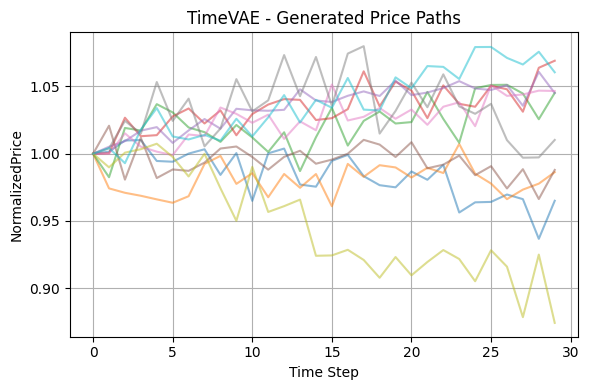

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot post-processed paths
for i in range(10):
    axs.plot(df_post_processed.iloc[i, :], alpha=0.5)


axs.set_title('TimeVAE - Generated Price Paths')
axs.set_xlabel('Time Step')
axs.set_ylabel('NormalizedPrice')
axs.grid(True)

plt.tight_layout()
plt.show()

(1060, 30, 1)
(100000, 30, 1)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2120 samples in 0.000s...
[t-SNE] Computed neighbors for 2120 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2120
[t-SNE] Computed conditional probabilities for sample 2000 / 2120
[t-SNE] Computed conditional probabilities for sample 2120 / 2120
[t-SNE] Mean sigma: 0.032206
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.326721
[t-SNE] KL divergence after 300 iterations: 1.615710


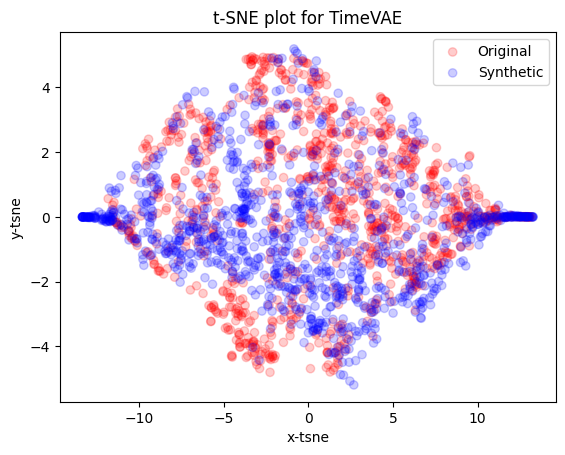

In [7]:
from visualisation import visualization

train_data_vis = np.array(train_data[["Close"]].values)
train_data_vis = np.array([train_data_vis[i:i+30] for i in range(len(train_data_vis)-30 + 1)])
train_data_vis = train_data_vis / train_data_vis[:, 0:1]

df_post_processed_vis = np.array(df_post_processed.values)
df_post_processed_vis = df_post_processed_vis[..., np.newaxis]

print(train_data_vis.shape)
print(df_post_processed_vis.shape)

visualization(ori_data=train_data_vis, generated_data=df_post_processed_vis, analysis='tsen', data_generating_model="TimeVAE", compare=train_data_vis.shape[0])